## Milestone 4: Deep learning

For this milestone you will (finally) use deep learning to predict movie genres. You will train one small network from scratch on the posters only, and compare this one to a pre-trained network that you fine tune. [Here](https://keras.io/getting-started/faq/#how-can-i-use-pre-trained-models-in-keras) is a description of how to use pretrained models in Keras.

You can try different architectures, initializations, parameter settings, optimization methods, etc. Be adventurous and explore deep learning! It can be fun to combine the features learned by the deep learning model with a SVM, or incorporate meta data into your deep learning model. 

**Note:** Be mindful of the longer training times for deep models. Not only for training time, but also for the parameter tuning efforts. You need time to develop a feel for the different parameters and which settings work, which normalization you want to use, which model architecture you choose, etc. 

It is great that we have GPUs via AWS to speed up the actual computation time, but you need to be mindful of your AWS credits. The GPU instances are not cheap and can accumulate costs rather quickly. Think about your model first and do some quick dry runs with a larger learning rate or large batch size on your local machine. 

The notebook to submit this week should at least include:

- Complete description of the deep network you trained from scratch, including parameter settings, performance, features learned, etc. 
- Complete description of the pre-trained network that you fine tuned, including parameter settings, performance, features learned, etc. 
- Discussion of the results, how much improvement you gained with fine tuning, etc. 
- Discussion of at least one additional exploratory idea you pursued

### Model from scratch

We based the deep network that we trained from scratch on the Keras_CNN example provided on the course website. CNN stands for convolutional neural network, a type of network that is specifically designed to work with image data. CNN’s work by arranging neurons in three dimensions, however each layer is only connected to a small portion of the layer before it. Were this not the case, the exponential number of connections would be unmanageable. 

The network combines a number of types of layers: Conv2D, Max Pooling, Dropout, Flatten, and Dense. The features passed in were square, resized 100x100 RGB arrays derived from the posters. The network passed these features through each layer, transforming them to try to pull out distinct feature representations that would indicative of a particular genre of movie. The final layer produced an array of length 19 that contains a probability for each genre. Our model ran through 100 epochs, with a starting learning rate of 0.01 and batch size of 100. We found that smaller batch sizes with smaller learning rates decreased our test accuracy significantly, likely because there was too much noise to produce any useful results. 

The network made use of ReLu and sigmoid activation functions. The ReLu function maps any value less than 0 to 0, and any value 0 or greater to itself. The sigmoid function is an activation function with a positive limit at 1 and a negative limit at -1. It has a smooth activation gradient through 0. ReLu is a particularly good activation function for dealing with nonlinearity, which is why we implemented that for most of our layers. For our final layer, we had the choice between a sigmoid and a softmax function; we decided to choose a sigmoid activation function, because softmax is only useful when we have a unique label for each movie. Softmax assigns probabilities to the different classes so that they sum to 1, and then chooses the class with the highest probability; however, because we are implementing multilabel classification (rather than multiclass classification), we opted for the sigmoid activation for our output layer. 

The model was optimized using stochastic gradient descent. SGD works by iteratively taking the gradient of the defined loss function (in this case categorical cross entropy) against the weight of each node, and updating the nodes with a learning rate. After a certain number of epochs, SGD should make the network converge to a local optimum.

Upon running this model, we found that overfitting of the training set was severely affecting the accuracy of our test set, and thus decided to incorporate some regularization parameters to prevent such overfitting. Firstly, in our output layer, we added a kernel_regularizer parameter, that performed L2 regularization. Secondly, we used an `EarlyStopping` function, which essentially ended the fitting of the model if the validation loss stabilized or decreased for 5 epochs; this was particularly helpful for both decreasing the runtime of the model (since it no longer iterated through all 100 epochs), as well as increasing the accuracy of the test set (because it only ran for as long as the validation loss decreased). Finally, we implemented a `LearningRateScheduler` function, which decreased the learning rate once the number of epochs passed 50. 

After determining a good structural layering for the network, we set about tuning it. We were particularly interested in tuning an optimum threshold for converting a probabilistic value into a binary prediction of genre. To do this, we tried values in the range from 0 to 1, and found that a threshold of 0.55 was optimal. 

To define our accuracy, we used the same metric that we used in the previous milestone. For each movie, we generated a set of all genres that were either 1 in the predictions or the labels or both. We then took the mean number of times that the predicted value and true value matched over this set. This was a better metric than standard accuracy because most of the labels were 0, so standard accuracy could have gotten a high accuracy with predictions that were all 0’s. Using our best structure and threshold values, we achieved an accuracy of 0.348.

In [1]:
from itertools import chain
from keras import regularizers
from keras.applications.vgg16 import VGG16
from keras.callbacks import EarlyStopping, LearningRateScheduler
from keras.layers import Activation, Conv2D, Dense, Dropout, Flatten, Input, MaxPooling2D
from keras.models import Model, Sequential
from keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from sklearn.model_selection import train_test_split

import h5py as h5py
import keras.backend as K
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

Using TensorFlow backend.


In [2]:
%matplotlib inline
matplotlib.rcParams.update({'font.size': 6})

In [3]:
# Merge lists of lists into a single list
def flatten(lst):
    return list(chain.from_iterable(lst))

def img_to_matrix(img, size=(100, 100)):
    img = img.resize(size)
    img = np.array(img)
    return img

def flatten_image(img):
    """
    takes in an (m, n) numpy array and flattens it 
    into an array of shape (1, m * n)
    """
    s = img.shape[0] * img.shape[1]
    img_wide = img.reshape(1, s)
    return img_wide[0]

def score_genres(y_true, y_pred, threshold=0.5):
    predicted = np.array([[int(p > threshold) for p in row] for row in y_pred])
    means = []
    
    for pred, actual in zip(predicted, y_true):
        label_ind = np.unique(np.concatenate((np.nonzero(pred), np.nonzero(actual)), axis=1))
        means.append(np.mean(pred[label_ind] == actual[label_ind]))
        
    return np.mean(means)

def score_plot_genres(model, x_test, y_true, thresholds=np.arange(0, 1, 0.025)):
    predictions = model.predict(x_test)
    scores = [score_genres(y_test, predictions, t) for t in thresholds]

    plt.figure(figsize=(4.5, 2.5), dpi=200)
    plt.plot(thresholds, scores, color='#2196F3', linewidth=0.75)
    plt.title('Score vs Probability Threshold - Max {:.3f} with t = {:.3f}'
              .format(np.max(scores), thresholds[np.argmax(scores)]))
    plt.xlabel('Threshold'); plt.ylabel('Score')
    plt.grid(); plt.tight_layout(); plt.show()
    
def history_plot(history):
    plt.figure(figsize=(4, 2), dpi=200)
    plt.plot(history.history['recall'], color='#2196F3', linewidth=0.75)
    plt.title('Recall Accuracy vs Epoch')
    plt.xlabel('Epoch'); plt.ylabel('Accuracy')
    plt.tight_layout(); plt.show()

# Multi-label scoring function from an unreleased version of Keras
# https://github.com/fchollet/keras/blob/c2e36f369b411ad1d0a40ac096fe35f73b9dffd3/keras/metrics.py
def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

# Creates a bar plot with recall accuracy, false negative rate, and false positive rate per genre
def plot_genre_accuracy(model, x_test, y_test, threshold=0.5):
    predicted = np.array([[int(p > threshold) for p in row] for row in model.predict(x_test)])
    correct_recall, false_neg, false_pos, genre_inds = [], [], [], np.arange(19)

    for genre in genre_inds:
        false_n_ind = np.nonzero(y_test[:, genre])
        false_p_ind = np.nonzero(predicted[:, genre])
        recall_slice = predicted[false_n_ind, genre] == y_test[false_n_ind, genre]
        false_n_slice = predicted[false_n_ind, genre] != y_test[false_n_ind, genre]
        false_p_slice = predicted[false_p_ind, genre] != y_test[false_p_ind, genre]
        correct_recall.append(np.mean(recall_slice) * 100 if recall_slice.any() else 0)
        false_neg.append(np.mean(false_n_slice) * 100 if false_n_slice.any() else 0)
        false_pos.append(np.mean(false_p_slice) * 100 if false_p_slice.any() else 0)

    plt.figure(figsize=(5.5, 3), dpi=200)
    ax = plt.subplot()

    ax.bar(genre_inds - 0.2, correct_recall, width=0.2, color='#81C784', align='center', label='Correct Recall')
    ax.bar(genre_inds, false_pos, width=0.2, color='#7E57C2', align='center', label='False Positive')
    ax.bar(genre_inds + 0.2, false_neg, width=0.2, color='#29B6F6', align='center', label='False Negative')

    ax.set_xticks(genre_inds)
    ax.set_xticklabels(genre_names)
    plt.setp(plt.xticks()[1], rotation=90)

    # Make legend box slighly less ugly
    legend = plt.legend()
    legend.get_frame().set_linewidth(0.5)

    plt.xlabel('Genre'); plt.ylabel('Percentage'); plt.title('Accuracy by Genre')
    plt.tight_layout(); plt.show()

In [4]:
img_width, img_height, batch_size, num_classes, epochs = 100, 100, 100, 19, 100

# Shape of input images
input_shape = (img_width, img_height, 3)

genre_names = np.load('./datasets/genre_names.npy')
genres = pd.read_pickle('./datasets/genres.pkl')
posters = pd.read_pickle('./datasets/posters_py3.pkl')

# The data, shuffled and split between train and test sets
ims = np.array([img_to_matrix(img.convert('RGB')) for img in posters['poster']])
x_train, x_test, y_train, y_test = train_test_split(ims, genres, test_size=0.2)
y_train, y_test = np.array(y_train), np.array(y_test)

# Normalize image values to [0, 1]
x_train_norm = x_train.astype('float32') / 255
x_test_norm = x_test.astype('float32') / 255

print('x_train shape:', x_train_norm.shape)
print('y_train shape:', y_train.shape)
print('x_test shape:', x_test_norm.shape)
print('y_test shape:', y_test.shape)

x_train shape: (6695, 100, 100, 3)
y_train shape: (6695, 19)
x_test shape: (1674, 100, 100, 3)
y_test shape: (1674, 19)


In [5]:
# create an empty network model
model = Sequential()
# --- input layer ---
model.add(Conv2D(16, kernel_size=(5, 5), activation='relu', input_shape=input_shape))
# --- max pool ---
model.add(MaxPooling2D(pool_size=(2, 2)))
# dropout layer
model.add(Dropout(0.25))

# --- next layer ---
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
# --- max pool ---
model.add(MaxPooling2D(pool_size=(2, 2)))

# --- next layer ---
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
# --- max pool ---
model.add(MaxPooling2D(pool_size=(2,2)))

# flatten for fully connected classification layer
model.add(Flatten())
# --- fully connected layer ---
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
# --- classification into 19 classes ---
# use sigmoid layer because of multilabel classification and regularize to prevent overfitting
model.add(Dense(19, activation='sigmoid', kernel_regularizer=regularizers.l2(0.01))) 

# prints out a summary of the model architecture
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 96, 96, 16)        1216      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 48, 48, 16)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 48, 48, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 46, 46, 32)        4640      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 23, 23, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 21, 21, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 10, 10, 64)        0         
__________

In [6]:
# decay learning rate after certain number of epochs
def step_decay(epoch): 
    lrate = 0.01
    if epoch > 50:
        lrate = 0.01 / (2. ** epoch)
    return lrate

lr = LearningRateScheduler(step_decay)

# set parameters for optimizer
sgd = SGD(lr=0.01, momentum=0.9)

# compile model with specific loss function and optimizer
model.compile(loss='categorical_crossentropy',
              optimizer=sgd,
              metrics=[recall])

# stop model early if validation loss stabilizes or decreases
early_stopping = EarlyStopping(monitor='val_loss', patience = 5)

# fit model and check on validation data 
history = model.fit(x_train_norm, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=0,
                    validation_data=(x_test_norm, y_test), callbacks=[lr, early_stopping])
model.save_weights('./datasets/fc_weights.h5')

In [7]:
# evaluate model
score = model.evaluate(x_test_norm, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 5.98861089602
Test accuracy: 0.510820800935


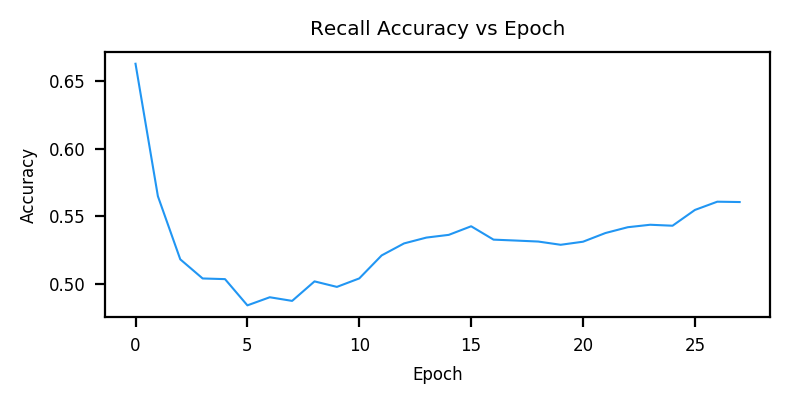

In [8]:
# Here is a visualization of the training process
history_plot(history)

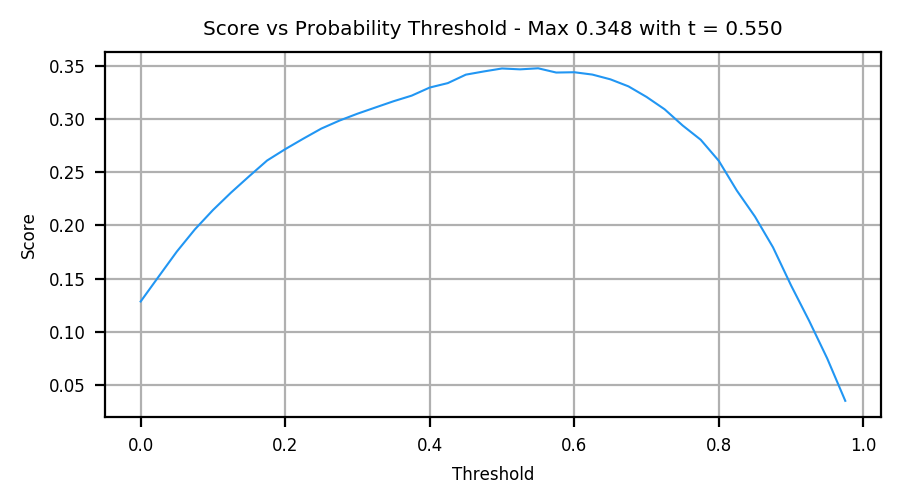

In [9]:
score_plot_genres(model, x_test_norm, y_test)

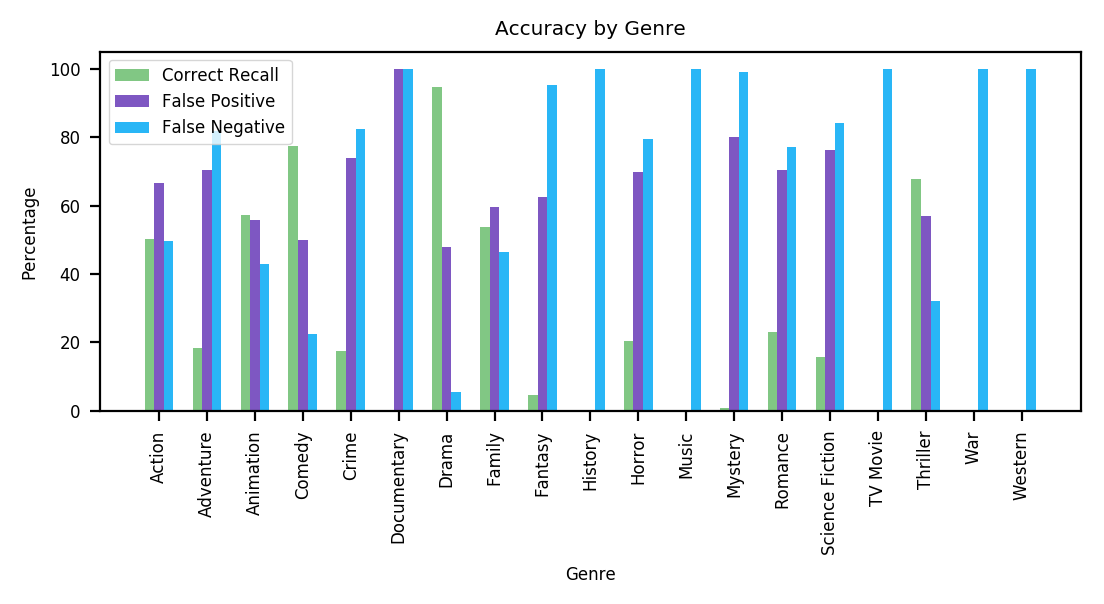

In [10]:
plot_genre_accuracy(model, x_test_norm, y_test)

Shape of W
(5, 5, 3, 16)


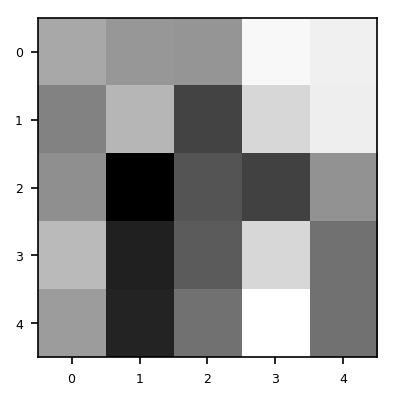

In [11]:
plt.figure(figsize=(3, 3), dpi=150)

# Look at the weights of the first layer
layer = model.layers[0]
weights = layer.get_weights()

# The weights are the number of pixels times the number of filters (hidden units)
print('Shape of W')
print(weights[0].shape)

# Look at the first filter
w = weights[0][:,:,0,0]
w = w.reshape((5,5))
plt.imshow(w, cmap='gray'); plt.show()

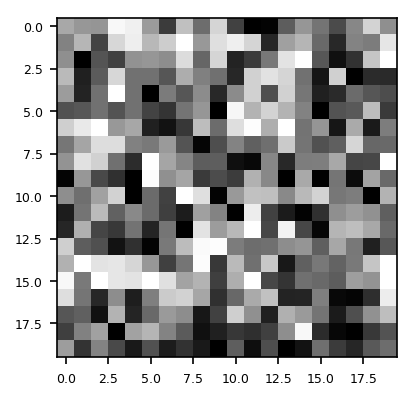

In [12]:
plt.figure(figsize=(3, 3), dpi=150)

# Make a figure for the first 25 filters
filterTiles = np.array([])
index = 0
for i in range(4):
    filterRow = []
    for j in range(4):
        w = weights[0][:, :, 0, index]
        w = w.reshape(5, 5)
        w = w - np.min(w)
        w = w / np.max(w)
        filterRow.extend(w)
        index += 1
    filterRow = np.array(filterRow)
    if not filterTiles.shape[0] == 0:
        filterTiles = np.hstack([filterTiles, filterRow])
    else:
        filterTiles = filterRow

plt.imshow(filterTiles, cmap='gray')
plt.show()

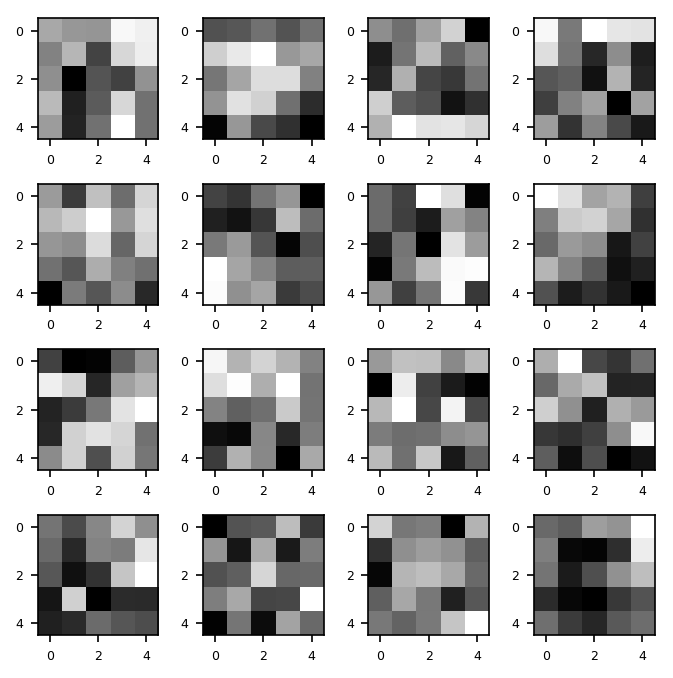

In [13]:
plt.figure(figsize=(4.5, 4.5), dpi=150)

# Make a figure for the first 25 filters
index = 0
for i in range(4):
    for j in range(4):
        w = weights[0][:, :, 0, index]
        w = w.reshape(5,5)
        index += 1
        plt.subplot(4, 4, index)
        plt.imshow(w, cmap='gray')    

plt.tight_layout(); plt.show()

### Fine-tuning VGG16

The pre-trained network that we decided to fine tune was the VGG16 model. This is the Keras model of the 16-layer network used by the VGG team in the ILSVRC-2014 competition. The details of the architecture can be found in the [arXiv paper](https://arxiv.org/abs/1409.1556). As shown from the documentation of the Keras models, the VGG16 model is used as the basis for several Keras example scripts, demonstrating its extensive use for deep learning. We also briefly tested the other models accessible through the Keras API (Xception, VGG19, ResNet50, Inception v3), but found that the VGG16 model resulted in a higher accuracy for the poster images.
For fine tuning the model, we followed the format presented in [this](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html) blog post.

First, we wanted to extract the “bottleneck features” of a pre-trained network. In order to accomplish this, we instantiated the convolutional part of the VGG16 network and trained that portion of the model using our training and validation data. Then, we extracted and stored the features from that part, and trained the connected-classifier using the previously obtained features. This increases computational efficiency, and makes sure that we don’t overfit the data. The connected model was 2 layers, using relu and sigmoid activation functions. These were used for the same reason as in the “made from scratch” model described above. From this method, we observed a max accuracy of 0.222 at a threshold of 0.125. We fitted the model using all possible optimizers, loss functions, and metrics but and found that the adam optimizer with a binary cross entropy loss function and the recall metric generated the most accurate predictions. 

After this, came the actual fine-tuning of the added fully-connected classifier to the convolutional part of the VGG16 model. First, we instantiated the convolutional layers of the model and loaded its weights. Next, we added the same fully-connected layer we used previously, and loaded its respective weights. Then, we froze all convolutional layers up until the last block. The reason why we first train the top-level classifier, and only then start fine-tuning convolutional weights alongside it is because otherwise, we could damage the weights learned from the convolution layers of the network. Finally, in order to fine-tune our top layers, we used a very slow learning rate. This is seen from our use of the SGD optimizer, rather than an adaptive learning rate optimizer such as RMSProp. Because of this, we were able to make sure that the magnitude of the updates stayed very small, as to not disrupt any of the features that we have previously learned. After fine tuning, we observed a max accuracy of 0.334 at a threshold of 0.6.

#### VGG16 features with smaller posters

In [14]:
datagen = ImageDataGenerator(rescale=1. / 255)

# Build the VGG16 network
vgg16_model = VGG16(include_top=False, weights='imagenet')

train_generator = datagen.flow(x_train, y_train, batch_size=batch_size)
test_generator = datagen.flow(x_test, y_test, batch_size=batch_size)

In [15]:
train_features = vgg16_model.predict_generator(train_generator, (x_train.shape[0] // batch_size) + 1)
test_features = vgg16_model.predict_generator(test_generator, (x_test.shape[0] // batch_size) + 1)

In [16]:
# Fit a model with VGG16 features using instructions from
# https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html
pre_model = Sequential()
pre_model.add(Flatten(input_shape=train_features.shape[1:]))
pre_model.add(Dense(128, activation='relu'))
pre_model.add(Dropout(0.5))
pre_model.add(Dense(19, activation='sigmoid'))

pre_model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=[recall])

history = pre_model.fit(train_features, y_train, epochs=epochs, batch_size=batch_size, 
                    validation_data=(test_features, y_test), verbose=0)

pre_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 4608)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               589952    
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 19)                2451      
Total params: 592,403.0
Trainable params: 592,403.0
Non-trainable params: 0.0
_________________________________________________________________


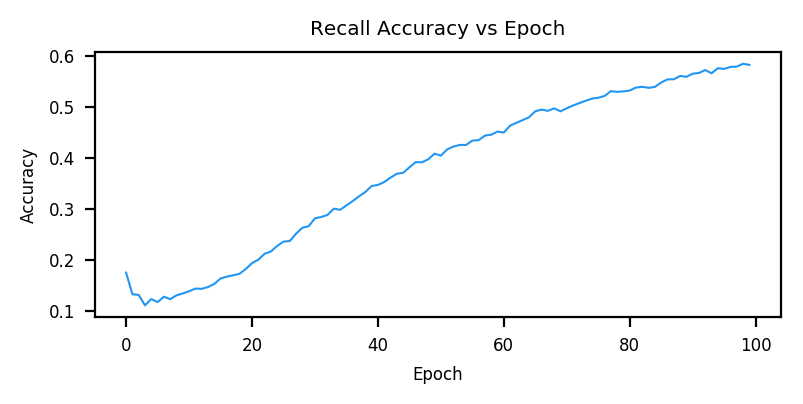

In [17]:
history_plot(history)

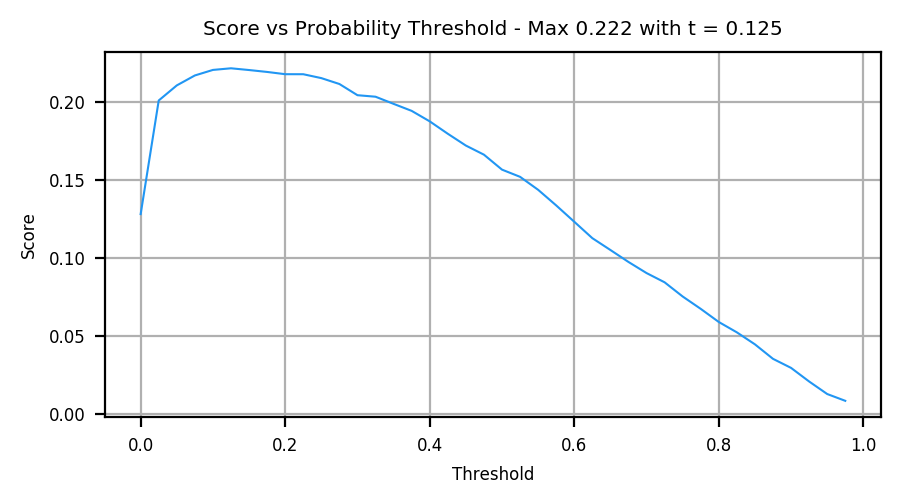

In [18]:
score_plot_genres(pre_model, test_features, y_test)

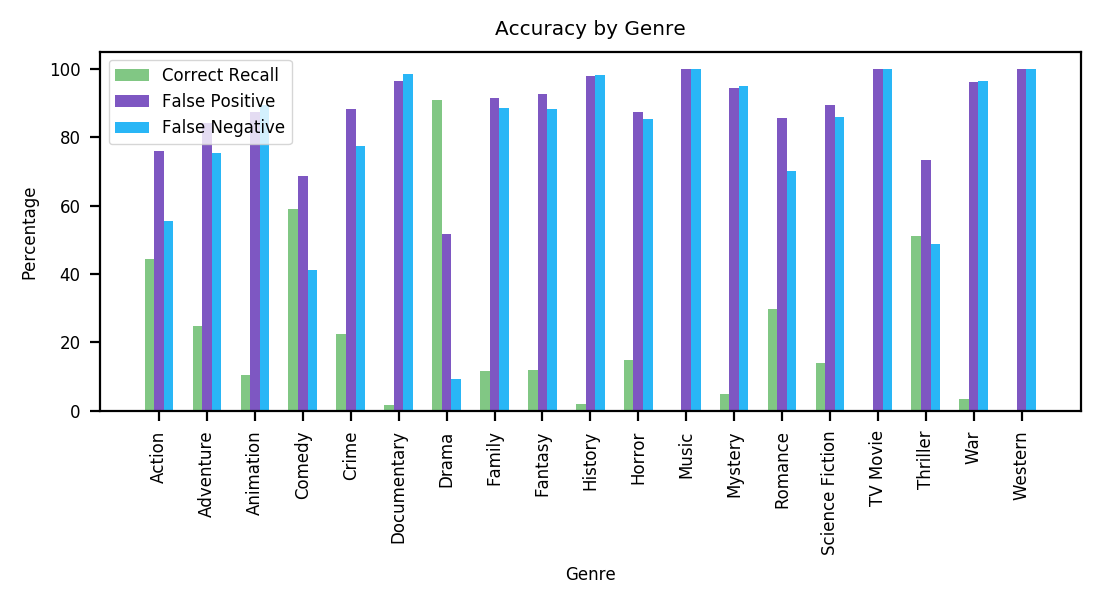

In [19]:
plot_genre_accuracy(pre_model, test_features, y_test, 0.125)

#### Full VGG16 model with new input and output layers

In [20]:
# Fine-tune VGG16 using instructions from
# https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html
vgg16 = VGG16(include_top=False, weights='imagenet')
vgg16_input = Input(shape=(img_width, img_height, 3), name='image_input')
vgg16_output = vgg16(vgg16_input)

# Add the fully-connected layers 
x = Flatten(name='flatten')(vgg16_output)
x = Dense(128, activation='relu', name='fc')(x)
x = Dropout(0.5)(x)
x = Dense(19, activation='sigmoid', name='predictions')(x)

# Set the first 25 layers (up to the last conv block) to non-trainable (weights will not be updated)
for layer in vgg16.layers[:25]:
    layer.trainable = False

# Compile the model with a SGD/momentum optimizer and a very slow learning rate
tuned_vgg16 = Model(inputs=vgg16_input, outputs=x)
tuned_vgg16.compile(loss='categorical_crossentropy',
                    optimizer=SGD(lr=1e-4, momentum=0.9), 
                    metrics=[recall])

tuned_vgg16.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
image_input (InputLayer)     (None, 100, 100, 3)       0         
_________________________________________________________________
vgg16 (Model)                multiple                  14714688  
_________________________________________________________________
flatten (Flatten)            (None, 4608)              0         
_________________________________________________________________
fc (Dense)                   (None, 128)               589952    
_________________________________________________________________
dropout_4 (Dropout)          (None, 128)               0         
_________________________________________________________________
predictions (Dense)          (None, 19)                2451      
Total params: 15,307,091.0
Trainable params: 592,403.0
Non-trainable params: 14,714,688.0
____________________________________________________

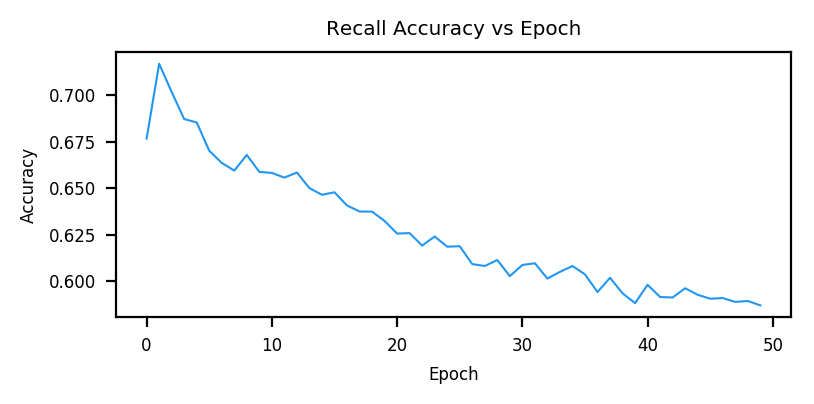

In [21]:
history = tuned_vgg16.fit(x_train_norm, y_train,
                          batch_size=batch_size,
                          callbacks=[early_stopping],
                          epochs=50,
                          validation_data=(x_test_norm, y_test),
                          verbose=0)

tuned_vgg16.save_weights('./datasets/vgg16_weights.h5')

history_plot(history)

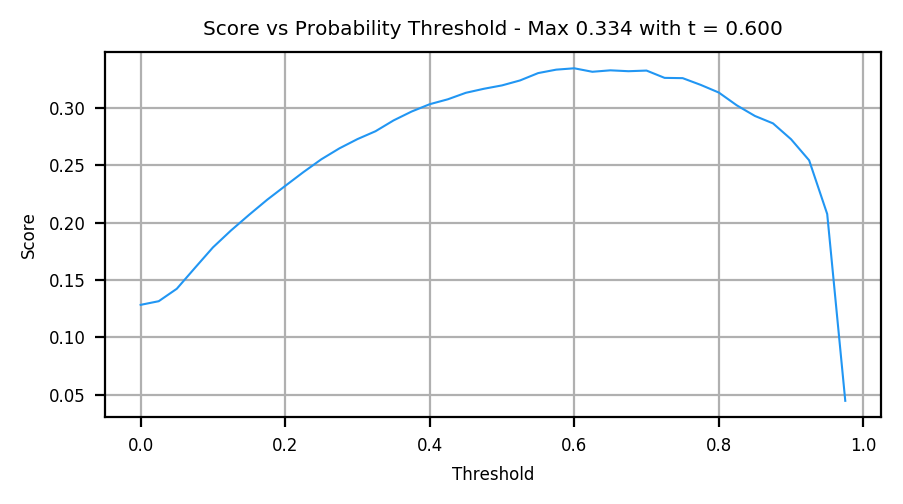

In [22]:
score_plot_genres(tuned_vgg16, x_test_norm, y_test)

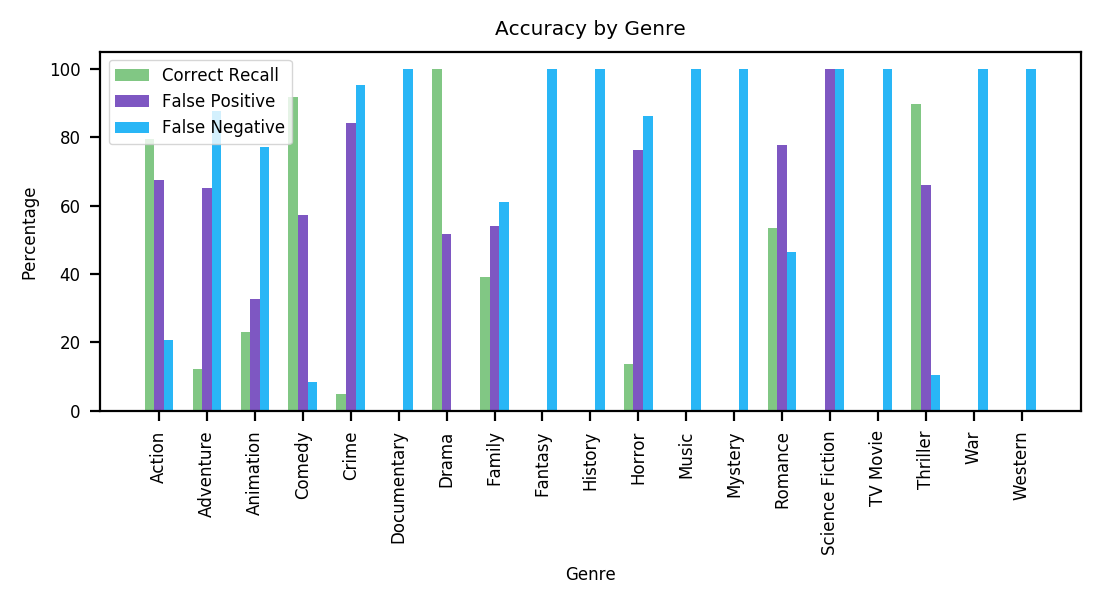

In [23]:
plot_genre_accuracy(tuned_vgg16, x_test_norm, y_test)

### Weight tuning

In [24]:
def trainer(weights):
    history = model.fit(x_train_norm, y_train,
        batch_size=batch_size,
        callbacks=[lr, early_stopping],
        class_weight=weights,
        epochs=epochs,
        validation_data=(x_test_norm, y_test),
        verbose=0)

    out = model.predict(x_test_norm)
    return score_genres(y_test, out)

In [25]:
weight_boosts, scores = np.arange(0.01, 0.11, 0.01), []
weights, df_ytrain = {}, pd.DataFrame(y_train)

for i in range(0,19):
    frac = float(df_ytrain[df_ytrain[i] == 1].shape[0]) / float(df_ytrain.shape[0])
    weights[i] = frac

for boost in weight_boosts:
    new_weights = {}
    
    for i in weights.keys():
        if weights[i] < boost:
            new_weights[i] = boost
        else:
            new_weights[i] = weights[i]
    
    scores.append(trainer(new_weights))

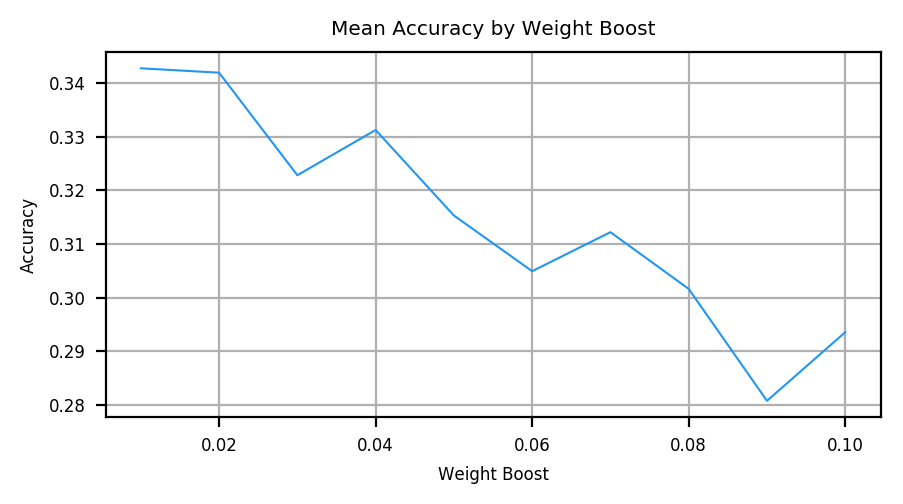

In [26]:
plt.figure(figsize=(4.5, 2.5), dpi=200)
plt.plot(weight_boosts, scores, color='#2196F3', linewidth=0.75)
plt.title('Mean Accuracy by Weight Boost')
plt.xlabel('Weight Boost'); plt.ylabel('Accuracy')
plt.grid(); plt.tight_layout(); plt.show()

### Discussion of results

If we observe the graphs and output accuracies of the VGG16 model before and after fine-tuning, we can see a clear increase in performance after. Optimally, we want higher accuracies to be correlated with higher thresholds when assigning genres to the movies because that demonstrates higher certainty. For example, before fine-tuning, the threshold is 0.125, meaning that we are assigning that specific genre to the movie if the probability for that genre is above 0.125. If a probability that low is giving us the highest score, then we can not be confident in that model, especially since it is giving us a score of 0.222, which is also very low. The graph also shows that the score decreases as the threshold increases, further depicting the limitations of the model. After fine-tuning, we see the opposite. The score and threshold are positively correlated as shown from the line graph. The threshold and score significantly increased to 0.6 and 0.334, respectively. We can see that this model has become more reliable in terms of classification and accuracy.

The results of the scratch model are slightly higher than the fine-tuned model, likely because we have actually trained the model on our movie posters rather than the random images that the VGG16 model used for training. After regularizing and tuning the threshold (described above), we achieved an accuracy of .348. Prior to regularizing and tuning, we experienced overfitting of the training model, which caused our accuracy to range between .29 and .31.

### Additional exploration

When looking at the bar graphs for correct labels, false negatives, and false positives over each genre, we saw that some genres were entirely false negatives, meaning that the genre was not receiving a 1 prediction for any movie. These were genres that were rare in the data, like “War” and “Western.” 

To try to rectify this, we thought of ways to change the class weights to push the probabilities up on these rare genres. We started by creating a weight dictionary where each genre weight was the rate of that genres occurrence in the training data. We then set a weight boost threshold and raised any genre that had a rate less than the threshold to the threshold. We tuned this threshold value, but ultimately found that it did not add anything to the accuracy.